In [2]:
from astropy.io import fits
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import os
import numpy as np
from winterdrp_offline.utils import plot_image, write_image, get_table_from_ldac
from winterdrp_offline.image_operations import median_combine_images, normalize_and_median_combine_images, split_data_into_channels, merge_channels_into_data
from winterdrp_offline.astrometry import get_astrometry_header_from_scamped_file
from winterdrp_offline.sextractor import run_sextractor
from winterdrp_offline.scamp import get_tmass_gaia_catalog_for_image
from winterdrp_offline.photcal import xmatch_img_ref_cats, calculate_zeropoint_outlier_rejection

In [3]:
# Set up the directories
base_dir = Path(os.path.join(os.getenv("HOME"), "data", "calibration_hackathon", "hackathon_datasets"))
print(base_dir)
name = 'ZTF25aadlqhw'
night = '20250220'
boardid = 4

target_dir = base_dir.joinpath(f'{name}/{night}/{boardid}/')

/Users/nlourie/data/calibration_hackathon/hackathon_datasets


In [4]:
raw_list = glob(str(target_dir.joinpath('raw_unpacked/*fits')))
print(f"Found {len(raw_list)} raw files in {target_dir}")

Found 8 raw files in /Users/nlourie/data/calibration_hackathon/hackathon_datasets/ZTF25aadlqhw/20250220/4


Loading WINTERcamera_20250221-072719-143_mef_4_0_0.fits
(1096, 1984)
min/max: 4820.0/58913.0
(16, 16)


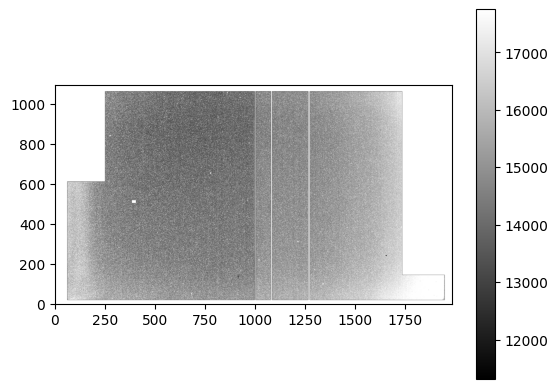

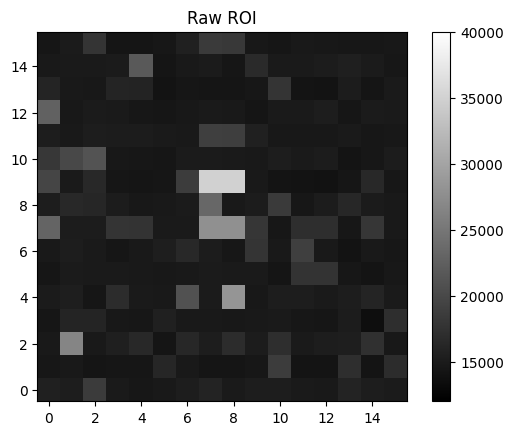

In [41]:
# Load a raw_unpacked file
img_file = "WINTERcamera_20250221-072719-143_mef_4_0_0.fits"
print(f"Loading {img_file}")
raw_img = fits.getdata(target_dir.joinpath('raw_unpacked', img_file))
from astropy.visualization import ImageNormalize
norm = ImageNormalize(vmin=12000, vmax = 40000)
plot_image(raw_img)

print(raw_img.shape)

roi_center = [311, 1214]
roi_center = [147, 1025]
roi_width = 16
roi_height = 16
roi_coords = [roi_center[0] - roi_height//2, roi_center[0] + roi_height//2, roi_center[1] - roi_width//2, roi_center[1] + roi_width//2]
roi = raw_img[roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]
# astropy visualization norm:
vmin = np.nanmin(raw_img)
vmax = np.nanmax(raw_img)
print(f"min/max: {vmin}/{vmax}")
#norm = ImageNormalize(vmin=3000, vmax = 9000)
#norm = ImageNormalize(vmin=vmin, vmax=vmax)
ax = plot_image(roi, norm=norm)
ax.set_title( "Raw ROI")
print(roi.shape)

shape of channels: (8, 4)
norm: <astropy.visualization.mpl_normalize.ImageNormalize object at 0x12a880c10>


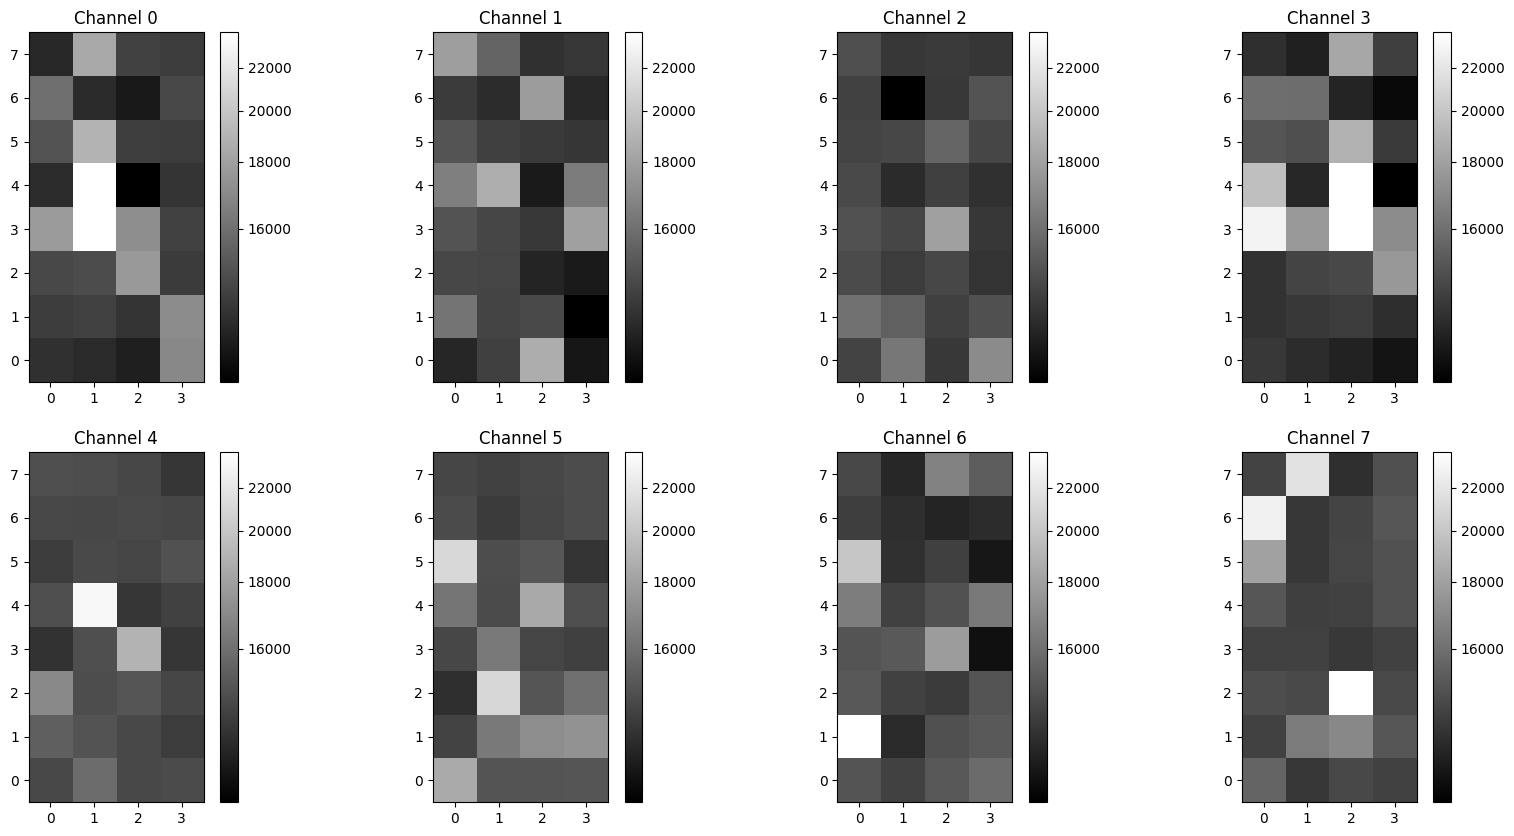

In [22]:
# Split the data up into channels
channels = split_data_into_channels(roi)
print(f"shape of channels: {channels[0].shape}")

# plot all the 8 channels. use the same color scale
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    # if it's the first image, grab the normalization 
    if i==0:
        ax, norm = plot_image(channels[i], ax=ax, return_norm=True, norm = "zscale")
        print(f"norm: {norm}")
    else:
        plot_image(channels[i], ax=ax, norm=norm)
    ax.set_title(f"Channel {i}")
    

plt.show()




In [23]:
# Load the dark file
dark_list = glob(str(target_dir.joinpath('calibration_darks/*fits')))
dark_img = fits.getdata(dark_list[0]) * 120.0 # Note the dark frames are normalized


Text(0.5, 1.0, 'Dark corrected ROI')

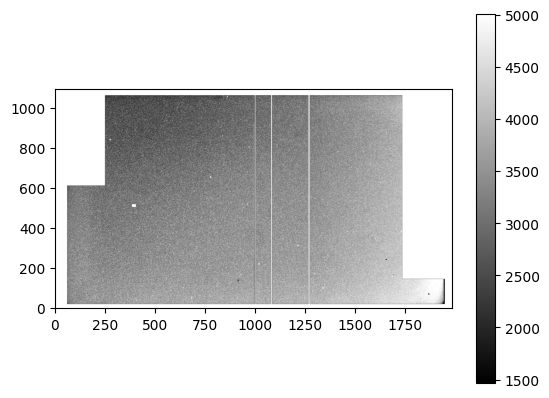

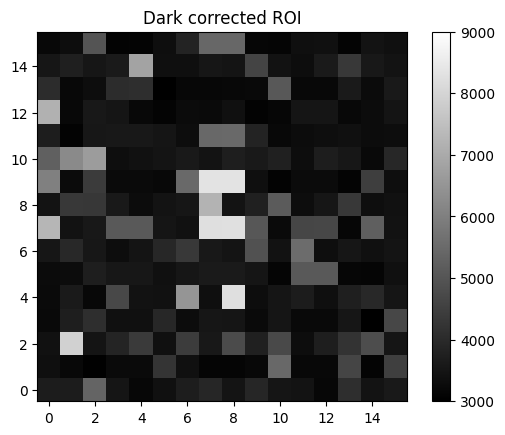

In [45]:
dark_calibrated_image = raw_img - dark_img
plot_image(dark_calibrated_image)

# plot the dark corrected ROI
dark_calibrated_roi = roi - dark_img[roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]
norm = ImageNormalize(vmin=3000, vmax = 9000)
plot_image(dark_calibrated_roi, norm=norm)
plt.title("Dark corrected ROI")

Found 10 flat lights in /Users/nlourie/data/calibration_hackathon/hackathon_datasets/flats/lab_flats/pc_2_60nA_post_mods_ptc-coarse
Found 10 flat darks in /Users/nlourie/data/calibration_hackathon/hackathon_datasets/flats/lab_flats/pc_2_60nA_post_mods_ptc-coarse
Saving flat to /Users/nlourie/data/calibration_hackathon/hackathon_datasets/flats/lab_flats/pc_2_60nA_post_mods_ptc-coarse/calibration_flats/lab_flat_0.06s.fits


Text(0.5, 1.0, 'Normalized flat ROI')

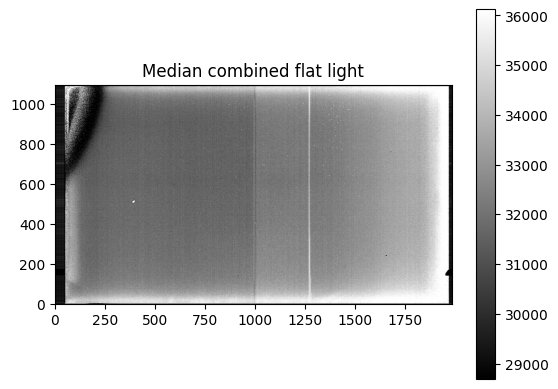

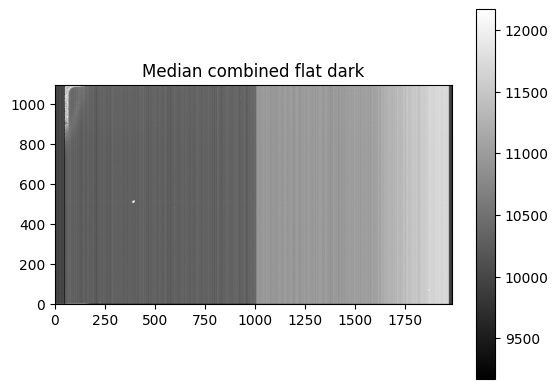

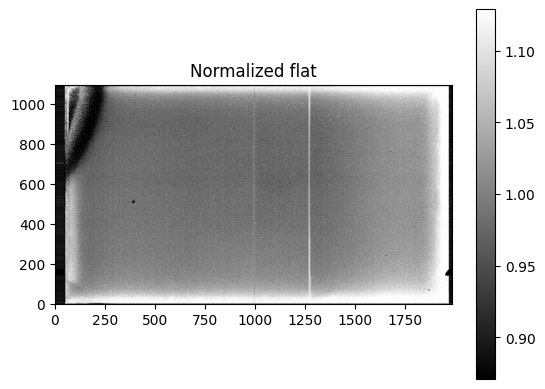

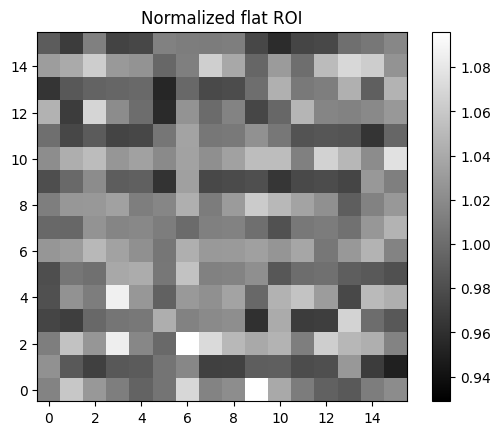

In [30]:
# Load a flat field
#flat_list = glob(str(target_dir.joinpath('calibration_flats/*fits')))
#flat_img = fits.getdata(flat_list[0])

flat_dir = base_dir.joinpath(f"flats/lab_flats/pc_2_60nA_post_mods_ptc-coarse")
flat_lights = glob(str(flat_dir.joinpath('flat/raw/*exp_0.06*fits')))
print(f"Found {len(flat_lights)} flat lights in {flat_dir}")
flat_darks = glob(str(flat_dir.joinpath('dark/raw/*exp_0.06*fits')))
print(f"Found {len(flat_darks)} flat darks in {flat_dir}")
# median combine the flat lights
flat_light_med = median_combine_images(flat_lights)
# plot the median combined flat
ax = plot_image(flat_light_med)
ax.set_title("Median combined flat light")

# median combine the flat darks
flat_dark_med = median_combine_images(flat_darks)
ax = plot_image(flat_dark_med)
ax.set_title("Median combined flat dark")

# subtract the dark from the light
flat_img = flat_light_med - flat_dark_med
# normalize the flat
flat_img = flat_img / np.nanmedian(flat_img)

#plot the flat
ax = plot_image(flat_img)
ax.set_title("Normalized flat")

# save the flat image
save_path = flat_dir.joinpath('calibration_flats/lab_flat_0.06s.fits')
print(f"Saving flat to {save_path}")
write_image(flat_img, save_path)

# plot the normalized flat ROI
flat_roi = flat_img[roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]
ax = plot_image(flat_roi)
ax.set_title("Normalized flat ROI")





Channel 0 mean: 0.9983 std: 0.0374
Channel 1 mean: 0.9863 std: -0.0383
Channel 2 mean: 0.9891 std: -0.0378
Channel 3 mean: 0.9874 std: 0.0381
Channel 4 mean: 0.9923 std: 0.0275
Channel 5 mean: 0.9924 std: 0.0273
Channel 6 mean: 0.9915 std: 0.0270
Channel 7 mean: 0.9898 std: 0.0271


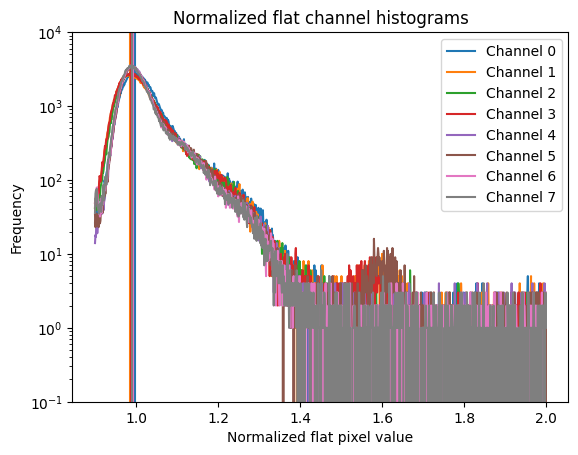

In [26]:

# plot histograms for each of the channels on the same plot
# channelize the normalized flat

from scipy.optimize import curve_fit
def gaussian(x, a, b, c):
    return a * np.exp(-(x - b)**2 / (2 * c**2))

flat_channels = split_data_into_channels(flat_img)
fig, ax = plt.subplots()
for i, channel in enumerate(flat_channels):
    binwidth = 50
    binmin = 0.9
    binmax = 2#1.1
    #print(f"min/max: {binmin}/{binmax}")
    w=binmax-binmin
    hist = np.histogram(
        np.ravel(channel), range=(binmin, binmax), bins=1000
    )
    xhist = hist[1][:-1]
    yhist= hist[0]
    mean_guess = np.nanmedian(channel)
    std_guess = np.nanstd(channel)
    ax.plot(xhist,yhist, label=f"Channel {i}")

    # fit a gaussian to the histogram
    hist_clipcond = yhist > (2000)  # & (xhist>mean_guess - 2000)
    xhist_clip = xhist[hist_clipcond]
    yhist_clip = yhist[hist_clipcond]

    popt, pcov = curve_fit(
        gaussian,
        xhist_clip,
        yhist_clip,
        p0=[max(yhist), mean_guess, std_guess],
        maxfev=5000,
    )
    
    x = np.linspace(binmin, binmax, 75)
    # plot the gaussian fit in the same color as the histogram
    #ax.plot(x, gaussian(x, *popt), label=f"Channel {i} fit", color=ax.get_lines()[-1].get_color())
    # print the mean and std of the fit
    print(f"Channel {i} mean: {popt[1]:.4f} std: {popt[2]:.4f}")
    # plot vertical lines for each channel's mean in the same color as the curve
    ax.axvline(popt[1], color=ax.get_lines()[-1].get_color())
    # plot the median as a dot for each channel with the same color as the curve

ax.set_title("Normalized flat channel histograms")
ax.set_xlabel("Normalized flat pixel value")
ax.set_ylabel("Frequency")
ax.set_yscale("log")
ax.set_ylim(.1, 1e4)
ax.legend()


Text(0.5, 1.0, '0.06s Lab Flat calibrated ROI')

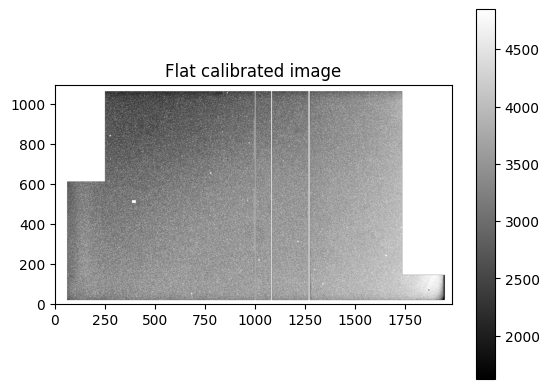

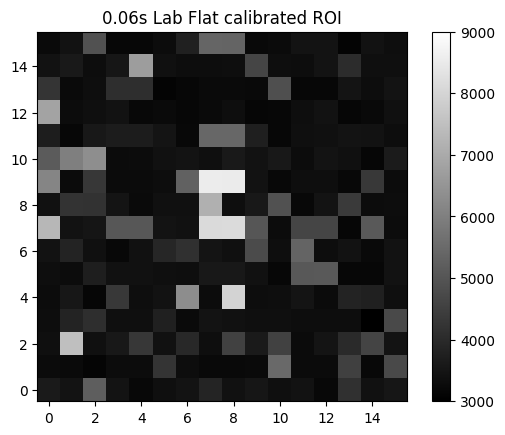

In [36]:
# Flat field the dark calibrated image

flat_img_path = flat_dir.joinpath('calibration_flats/lab_flat_0.06s.fits')
flat_img = fits.getdata(flat_img_path)

flat_calibrated_image = dark_calibrated_image / flat_img
ax = plot_image(flat_calibrated_image)
ax.set_title("Flat calibrated image")

# plot the flat calibrated ROI
flat_calibrated_roi = flat_calibrated_image[roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]
norm = ImageNormalize(vmin=np.nanmin(flat_calibrated_roi), vmax=np.nanmax(flat_calibrated_roi))
norm = ImageNormalize(vmin=3000, vmax = 9000)
ax = plot_image(flat_calibrated_roi, norm=norm)
ax.set_title("0.06s Lab Flat calibrated ROI")

Text(0.5, 1.0, 'Gain Flat calibrated ROI')

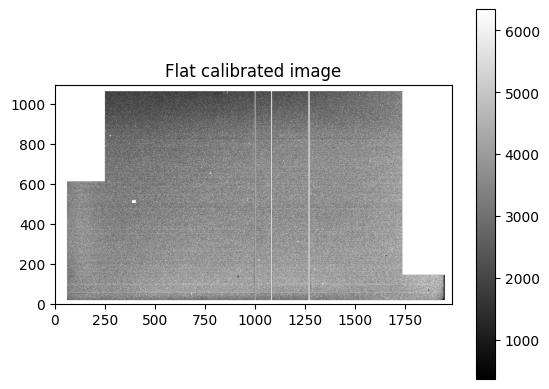

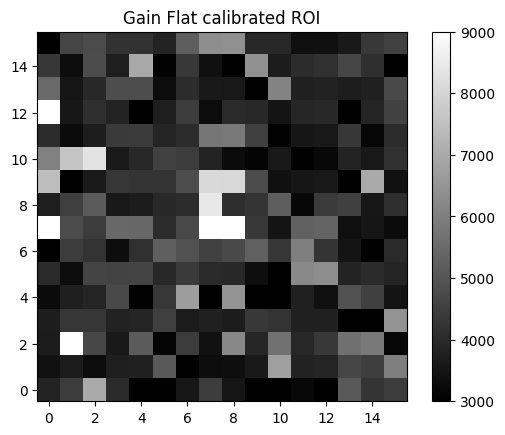

In [37]:
# Flat field the dark calibrated image

#flat_img_path = flat_dir.joinpath('calibration_flats/lab_flat_0.06s.fits')
flat_img_path = flat_dir.joinpath('calibration_flats/PC_IWR_Raw_-15C_gain_flat.fits')
flat_img = fits.getdata(flat_img_path)

flat_calibrated_image = dark_calibrated_image / flat_img
ax = plot_image(flat_calibrated_image)
ax.set_title("Flat calibrated image")

# plot the flat calibrated ROI
flat_calibrated_roi = flat_calibrated_image[roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]
norm = ImageNormalize(vmin=np.nanmin(flat_calibrated_roi), vmax=np.nanmax(flat_calibrated_roi))
norm = ImageNormalize(vmin=3000, vmax = 9000)
ax = plot_image(flat_calibrated_roi, norm=norm)
ax.set_title("Gain Flat calibrated ROI")

/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winterdrp_offline/winterdrp_offline/image_operations.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(data_array, axis=0)


<Axes: >

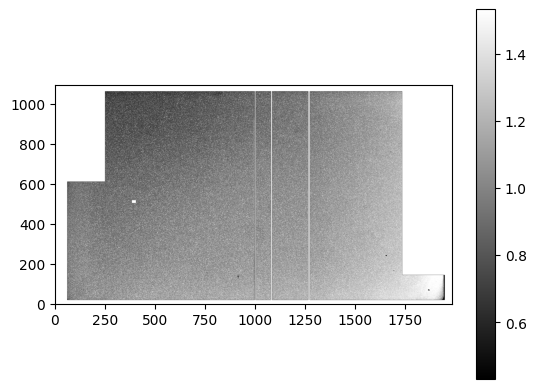

In [10]:
# Load all darkcal images and stack them to make a combined flat
darkcal_list = glob(str(target_dir.joinpath('darkcal/*fits')))
median_flat = median_combine_images(darkcal_list)
median_flat /= np.nanmedian(median_flat)
plot_image(median_flat)

/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winterdrp_offline/winterdrp_offline/image_operations.py:37: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(data_array, axis=0)


<Axes: >

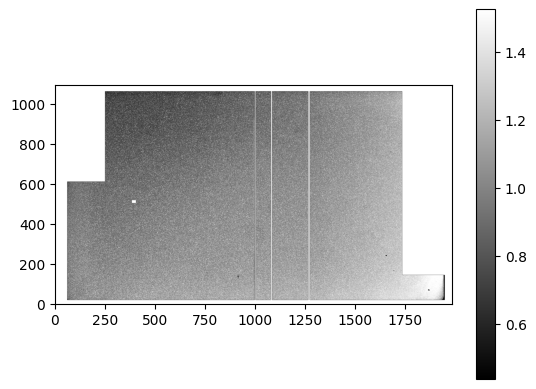

In [11]:
# Make flat by stacking normalized dark images
normalized_median_flat = normalize_and_median_combine_images(darkcal_list)
plot_image(normalized_median_flat)

<Axes: >

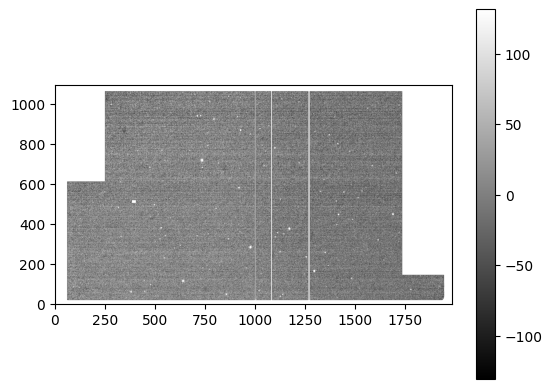

In [12]:
# Load a skysubtracted image
skysub_list = glob(str(target_dir.joinpath('skysub/*fits')))
skysub_img = fits.getdata(skysub_list[0])
plot_image(skysub_img)

In [13]:
# Assign an astrometry header from the post_scamp directory to this file and write it.
scamp_astrometry_header = get_astrometry_header_from_scamped_file(skysub_list[0])
skysub_scamped_filename = skysub_list[0].replace('skysub', 'skysub_scamped')
write_image(image=skysub_img, header=scamp_astrometry_header, filename=skysub_scamped_filename)

In [14]:
# Run sextractor on the skysubtracted image. With regions=True, a regions file
# with all detected sources is written in the target directory.
catname = run_sextractor(skysub_scamped_filename, weightimg=None, regions=True)

Executing command : sex -c /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winterdrp_offline/winterdrp_offline/config/astrom.sex /Users/nlourie/data/calibration_hackathon/hackathon_datasets/ZTF25aadlqhw/20250220/4/skysub_scamped/WINTERcamera_20250221-072926-636_mef_4_0_0.fits -CATALOG_NAME /Users/nlourie/data/calibration_hackathon/hackathon_datasets/ZTF25aadlqhw/20250220/4/skysub_scamped/WINTERcamera_20250221-072926-636_mef_4_0_0.fits.cat -CATALOG_TYPE FITS_LDAC -PARAMETERS_NAME /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winterdrp_offline/winterdrp_offline/config/astrom.param -FILTER_NAME /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winterdrp_offline/winterdrp_offline/config/default.conv -STARNNW_NAME /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winterdrp_offline/winterdrp_offline/config/default.nnw -PIXEL_SCALE 1.12 -DETECT_THRESH 3.0 -ANALYSIS_THRESH 3.0 -SATUR_LEVEL 60000.0 -WEIGHT_TYPE MAP_WEIGHT -WEIGHT_IMAGE /Users/nlourie/data/calibration_hackathon/hackathon_datasets/ZTF25aadlqhw/2025022

In [15]:
image_catalog = get_table_from_ldac(catname)

In [16]:
#filter sources
image_catalog = image_catalog[(image_catalog['MAG_AUTO'] < 99) & (image_catalog['FLAGS']==0) & (image_catalog['FWHM_WORLD']<4.0/3600.0)]


In [17]:
print(f"Found {len(image_catalog)} good sources in the catalog")

Found 1746 good sources in the catalog


In [18]:
ref_cat = get_tmass_gaia_catalog_for_image(skysub_scamped_filename, write_catalog=True, write_regions=True)

SELECT * FROM gaiadr2.gaia_source AS g, gaiadr2.tmass_best_neighbour AS tbest, gaiadr1.tmass_original_valid AS tmass WHERE g.source_id = tbest.source_id AND tbest.tmass_oid = tmass.tmass_oid AND CONTAINS(POINT('ICRS', g.ra, g.dec), CIRCLE('ICRS', 224.8358, 51.5488, 0.2500))=1 AND tmass.j_m > 7.00 AND tmass.j_m < 20.00 AND tbest.number_of_mates=0 AND tbest.number_of_neighbours=1;
INFO: Query finished. [astroquery.utils.tap.core]
Yay


KeyError: 'column "DESIGNATION" does not exist'

In [ ]:
xmatch_cat, xmatch_ref_cat = xmatch_img_ref_cats(image_catalog, ref_cat, xmatch_radius_arcsec=2)
print(f"Found {len(xmatch_cat)} matched sources")

Found 67 matched sources


Text(0.5, 0, '2MASS J mag')

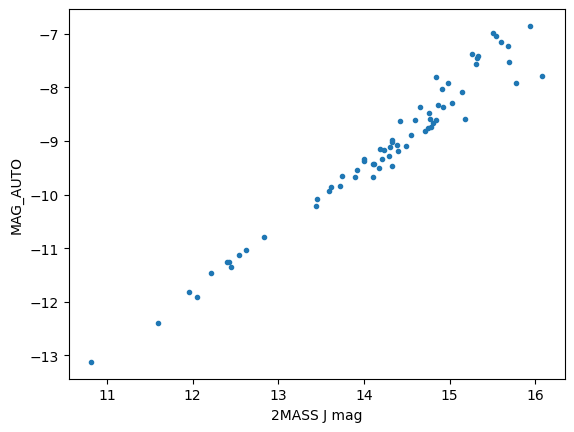

In [ ]:
plt.plot(xmatch_ref_cat['j_m'], xmatch_cat['MAG_AUTO'], '.')
plt.ylabel('MAG_AUTO')
plt.xlabel('2MASS J mag')

In [ ]:
zp, zpstd, nstars = calculate_zeropoint_outlier_rejection(xmatch_cat['MAG_AUTO'], xmatch_ref_cat['j_m'], outlier_rejection_thresholds=[1.5])

Text(0.5, 0, '2MASS J mag')

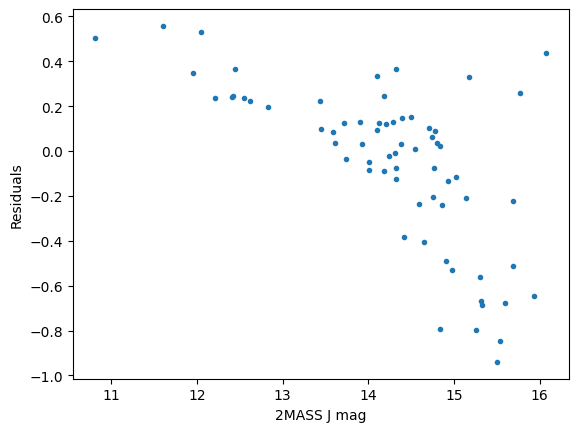

In [ ]:
residuals = xmatch_ref_cat['j_m'] - xmatch_cat['MAG_AUTO'] - zp
plt.plot(xmatch_ref_cat['j_m'], residuals, '.')
plt.ylabel('Residuals')
plt.xlabel('2MASS J mag')

In [ ]:
# Our goal is to improve this plot.